In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

infile='Bladder.txt'

testratio=26/74


df=pd.read_csv(infile,sep='\t')
df

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,utDNA,TF99
0,0,63,1,1,1,1,1,1,2.4,2.400
1,0,78,1,1,1,0,0,1,5.9,2.400
2,0,77,1,1,0,1,1,1,2.4,1.600
3,0,61,1,1,1,1,0,1,11.6,12.900
4,0,68,1,1,1,0,0,1,10.1,0.000
...,...,...,...,...,...,...,...,...,...,...
69,1,78,2,1,1,1,0,0,26.1,8.702
70,1,56,1,1,1,1,0,0,4.7,0.000
71,1,61,1,1,1,0,1,0,0.0,0.000
72,1,73,2,1,1,1,1,1,0.3,0.000


In [3]:
df_og = df.copy()
df_og['Sum'] = np.power((np.array(df['utDNA']) + 1e-3) / (np.array(df['TF99']) + 1), 0.005)
df_og = df_og.drop([ 'utDNA', 'TF99'], axis=1)

display(df_og)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Sum
0,0,63,1,1,1,1,1,1,0.998262
1,0,78,1,1,1,0,0,1,1.002761
2,0,77,1,1,0,1,1,1,0.999602
3,0,61,1,1,1,1,0,1,0.999096
4,0,68,1,1,1,0,0,1,1.011630
...,...,...,...,...,...,...,...,...,...
69,1,78,2,1,1,1,0,0,1.004960
70,1,56,1,1,1,1,0,0,1.007769
71,1,61,1,1,1,0,1,0,0.966051
72,1,73,2,1,1,1,1,1,0.994015


In [4]:
Xs = []
Ys = []

dfs = [df_og]
for df_val in dfs:
    X=df_val.drop(['pCR'],axis=1)
    Y=df_val["pCR"].copy()
    Xs.append(X)
    Ys.append(Y)

In [308]:
trainXs = []
testXs = []
trainYs = []
testYs = []
for i in range(len(Xs)):
    X_arr = Xs[i]
    Y_arr = Ys[i]
    trainX,testX,trainY,testY =  train_test_split(X_arr,Y_arr,test_size=testratio, random_state=0)
    trainXs.append(trainX)
    testXs.append(testX)
    trainYs.append(trainY)
    testYs.append(testY)

In [309]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc
for i in range(len(trainXs)):
    trainX_arr = trainXs[i]
    trainY_arr = trainYs[i]
    testX_arr = testXs[i]
    testY_arr = testYs[i]
    my_final_classifier = RandomForestClassifier(n_estimators=2000, oob_score=True)
    my_final_classifier.fit(trainX_arr, trainY_arr)
    pred = my_final_classifier.predict_proba(testX_arr)[:,1]
    pred_train = my_final_classifier.predict_proba(trainX_arr)[:,1]
    pred_all = my_final_classifier.predict_proba(trainX_arr.append(testX_arr))[:,1]

    print('Oob_score =', my_final_classifier.oob_score_)
    print('ROC Score =', roc_auc_score(testY_arr, my_final_classifier.predict_proba(testX_arr)[:,1]))
    
    fpr_train, tpr_train, thresholds_train = roc_curve(trainY_arr, pred_train)
    sens_train = tpr_train
    spec_train = 1 - fpr_train
    gmeans_train = np.sqrt(sens_train * spec_train)
    ix_train = np.argmax(gmeans_train)
    fpr, tpr, thresholds = roc_curve(testY_arr, pred)
    sens_pred = tpr
    spec_pred = 1 - fpr
    gmeans = np.sqrt(tpr * (1-fpr))
    # ix_train = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix_train], gmeans_train[ix_train]), '\n')

    fpr_all, tpr_all, thresholds_all = roc_curve(trainY_arr.append(testY_arr), pred_all)
    sens_all = tpr_all
    spec_all = 1 - fpr_all
    gmeans_all = np.sqrt(sens_all * spec_all)
    # ix_all = np.argmax(gmeans_all)

    df_ss = pd.DataFrame([[sens_pred[ix_train], spec_pred[ix_train]], \
                  [sens_train[ix_train], spec_train[ix_train]], \
                  [sens_all[ix_train], spec_all[ix_train]]],\
                 columns=['Sensitivity', 'Specificity'], index=['Test', 'Train', 'All'])
    display(df_ss)

Oob_score = 0.6041666666666666
ROC Score = 0.7916666666666667
Best Threshold=0.599000, G-Mean=1.000 



,Sensitivity,Specificity
Test,0.611111,1.0
Train,1.000000,1.0
All,0.805556,1.0


In [310]:
my_final_classifier.oob_score_

0.6041666666666666

In [311]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

roc_auc_score(testY, my_final_classifier.predict_proba(testX)[:,1])

0.7916666666666667

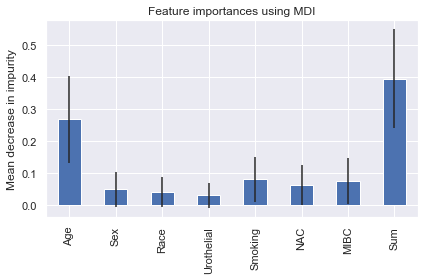

In [312]:
feature_names = X.columns
std = np.std([tree.feature_importances_ for tree in my_final_classifier.estimators_], axis=0)
importances = my_final_classifier.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [313]:
feature_names

Index(['Age', 'Sex', 'Race', 'Urothelial', 'Smoking', 'NAC', 'MIBC', 'Sum'], dtype='object')

In [314]:
X

,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Sum
0,63,1,1,1,1,1,1,0.998310
1,78,1,1,1,0,0,1,1.002768
2,77,1,1,0,1,1,1,0.999447
3,61,1,1,1,1,0,1,0.999089
4,68,1,1,1,0,0,1,1.011631
...,...,...,...,...,...,...,...,...
69,78,2,1,1,1,0,0,1.004957
70,56,1,1,1,1,0,0,1.007790
71,61,1,1,1,0,1,0,0.966051
72,73,2,1,1,1,1,1,0.993847


In [315]:
from sklearn.utils import shuffle
testfile = 'Bladder Project pCR Prediction Data (updated).txt'
df=pd.read_csv(testfile,sep='\t', index_col=0)
df = shuffle(df)
df

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,utDNA,TF99,PFS,PFSevent,OS,OSevent
ID,,,,,,,,,,,,,,
WBC1207,1,76,1,1,1,1,1,1,0.0,0.0,16.1,0.0,16.1,0
WBC1233,0,74,1,1,1,1,0,1,0.0,61.9,1.9,1.0,8.4,1
WBC1314,1,73,2,1,1,1,1,1,0.3,0.0,1.8,0.0,1.8,0
WBC1186,0,82,2,1,1,0,0,0,3.4,13.7,19.7,0.0,19.7,0
WBC1304,0,69,1,1,1,1,0,0,17.0,14.0,1.9,0.0,1.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBC1206,0,65,2,1,0,0,0,1,2.8,5.8,1.5,1.0,5.4,1
WBC1050,1,63,2,1,1,1,1,1,0.0,2.5,27.4,0.0,27.4,0
WBC1274,1,62,1,1,1,1,1,1,8.8,17.1,NaN,NaN,5.8,0


In [316]:
df_test = df.copy()
df_test['Sum'] = np.power((np.array(df['utDNA']) + 1e-3) / (np.array(df['TF99']) + 1), 0.005)
df_test = df_test.drop(['utDNA', 'TF99', 'PFS', 'PFSevent', 'OS', 'OSevent'], axis=1)

display(df_test)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Sum
ID,,,,,,,,,
WBC1207,1,76,1,1,1,1,1,1,0.966051
WBC1233,0,74,1,1,1,1,0,1,0.946252
WBC1314,1,73,2,1,1,1,1,1,0.994015
WBC1186,0,82,2,1,1,0,0,0,0.992708
WBC1304,0,69,1,1,1,1,0,0,1.000626
...,...,...,...,...,...,...,...,...,...
WBC1206,0,65,2,1,0,0,0,1,0.995575
WBC1050,1,63,2,1,1,1,1,1,0.960019
WBC1274,1,62,1,1,1,1,1,1,0.996401


In [317]:
from sklearn import metrics
X=df_test.drop(['pCR'],axis=1)
Y=df_test["pCR"].copy()
trainX,testX,trainY,testY =  train_test_split(X,Y,test_size=testratio, random_state=0, shuffle=False)
my_final_classifier = RandomForestClassifier(n_estimators=2000, oob_score=True)
my_final_classifier.fit(trainX, trainY)
pred = my_final_classifier.predict_proba(testX)[:,1]
pred_train = my_final_classifier.predict_proba(trainX)[:,1]
pred_all = my_final_classifier.predict_proba(trainX.append(testX))[:,1]

print('Oob_score =', my_final_classifier.oob_score_)
print('ROC Score =', roc_auc_score(testY, my_final_classifier.predict_proba(testX)[:,1]))

fpr_train, tpr_train, thresholds_train = roc_curve(trainY, pred_train)
sens_train = tpr_train
spec_train = 1 - fpr_train
gmeans_train = np.sqrt(sens_train * spec_train)
ix_train = np.argmax(gmeans_train)
fpr, tpr, thresholds = roc_curve(testY, pred)
sens_pred = tpr
spec_pred = 1 - fpr
gmeans = np.sqrt(tpr * (1-fpr))
# ix_train = np.argmax(gmeans)
thresh = thresholds[ix_train]
print('Best Threshold=%f, G-Mean=%.3f' % (thresh, gmeans_train[ix_train]), '\n')

fpr_all, tpr_all, thresholds_all = roc_curve(trainY.append(testY), pred_all)
sens_all = tpr_all
spec_all = 1 - fpr_all
gmeans_all = np.sqrt(sens_all * spec_all)
# ix_all = np.argmax(gmeans_all)

df_ss = pd.DataFrame([[sens_pred[ix_train], spec_pred[ix_train]], \
          [sens_train[ix_train], spec_train[ix_train]], \
          [sens_all[ix_train], spec_all[ix_train]]],\
         columns=['Sensitivity', 'Specificity'], index=['Test', 'Train', 'All'])
display(df_ss)
y_pred = my_final_classifier.predict(trainX.append(testX))
df_test['Prediction'] = y_pred
y_true = np.array(df_test['pCR'])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred), '\n')

Oob_score = 0.5208333333333334
ROC Score = 0.85
Best Threshold=0.711000, G-Mean=1.000 



,Sensitivity,Specificity
Test,0.700000,1.0
Train,1.000000,1.0
All,0.916667,1.0


Mean Absolute Error: 0.08108108108108109 



In [318]:
pred = my_final_classifier.predict(trainX.append(testX))
df_test['Prediction'] = pred
print(np.array(df_test['Prediction'] == df_test['pCR']))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True False  True  True False  True
  True  True  True  True False  True  True  True  True False  True  True
  True False]


In [319]:
df_test.head()

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Sum,Prediction
ID,,,,,,,,,,
WBC1207,1,76,1,1,1,1,1,1,0.966051,1
WBC1233,0,74,1,1,1,1,0,1,0.946252,0
WBC1314,1,73,2,1,1,1,1,1,0.994015,1
WBC1186,0,82,2,1,1,0,0,0,0.992708,0
WBC1304,0,69,1,1,1,1,0,0,1.000626,0
